In [1]:
import pandas as pd
import dew_gwdata as gd
from datetime import timedelta
import matplotlib.pyplot as plt

db = gd.sageodata()

In [2]:
%matplotlib inline
plt.rcParams["figure.dpi"] = 120

In [3]:
db.find

AttributeError: 'SAGeodataConnection' object has no attribute 'fin'

In [56]:
df = db.find_edits_by("MHUTCHESSON").pipe(gd.cleanup_columns)
df.head()

,well_id,obs_date,data_values,created_by,creation_date,modified_by,modified_date,comments,table
0,PLL040,2020-02-18,"DTW 59.43, SWL 59.43, RSWL 35.57",MHUTCHESSON,2020-02-21 10:57:40,MHUTCHESSON,2020-02-21 10:57:40,None,WL
0,HLD033,2020-02-20,"EC 10030, TDS 5726",MHUTCHESSON,2020-02-21 10:57:40,MHUTCHESSON,2020-02-21 10:57:40,None,Salinity
2,PLL040,2020-02-18,"EC 2710, TDS 1502",MHUTCHESSON,2020-02-21 10:57:40,MHUTCHESSON,2020-02-21 10:57:40,None,Salinity
3,MCG015,2020-02-19,"EC 3665, TDS 2039",MHUTCHESSON,2020-02-21 10:57:40,MHUTCHESSON,2020-02-21 10:57:40,None,Salinity
1,PEB035,2020-02-18,"DTW 41.72, SWL 41.01, RSWL 37.18",MHUTCHESSON,2020-02-21 10:57:40,MHUTCHESSON,2020-02-21 10:57:40,None,WL


In [57]:
df.tail()

,well_id,obs_date,data_values,created_by,creation_date,modified_by,modified_date,comments,table
80809,CAD026,2012-06-18,"DTW , SWL , RSWL",MCARTA01,2012-06-20 16:11:10,MHUTCHESSON,2013-05-16 11:22:06,To wet under water,WL
80810,5737-860,2013-04-14,"DTW 10.2, SWL 10.2, RSWL 139.1",MHUTCHESSON,2013-05-01 11:34:05,MHUTCHESSON,2013-05-01 11:34:22,None,WL
5249,JES069,2013-04-17,"EC 2056, TDS 1136",MHUTCHESSON,2013-04-19 13:51:20,MHUTCHESSON,2013-04-19 13:52:36,None,Salinity
5250,BRA038,2013-03-01,"EC 49320, TDS 32150",MHUTCHESSON,2013-04-19 13:38:35,MHUTCHESSON,2013-04-19 13:38:40,None,Salinity
80811,WNL098,2010-10-28,"DTW 17.6, SWL 17.09, RSWL 131.54",KELLYC01,2010-10-28 15:05:03,MHUTCHESSON,2012-09-20 16:03:05,Triple completion- WNL97(W9B)DTW=7.08m; WNL96(...,WL


In [58]:
from matplotlib import dates as mdates

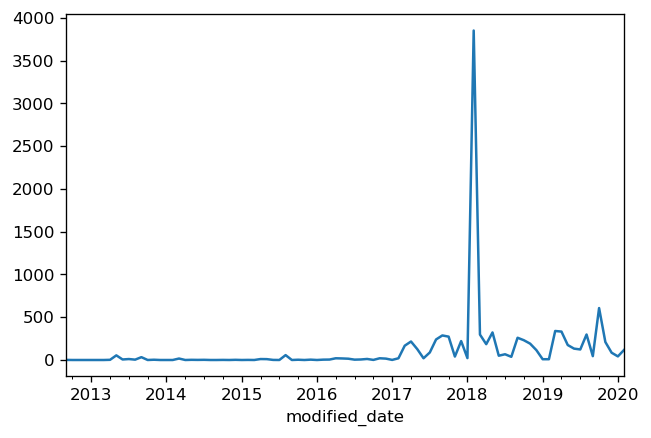

In [59]:
df.set_index("modified_date").groupby(pd.Grouper(freq="M")).obs_date.count().plot(
    kind="line"
)

In [88]:
wl_sql = """
select 
dh.drillhole_no AS dh_no,
         dh.unit_no      AS unit_long,
         To_char(dh.map_100000_no)
                  || '-'
                  || To_char(dh.dh_seq_no) AS unit_hyphen,
         Trim(To_char(dh.obs_well_plan_code))
                  || Trim(To_char(dh.obs_well_seq_no, '000')) AS obs_no,
         dh.dh_name,
         dh.amg_easting      AS easting,
         dh.amg_northing     AS northing,
         dh.amg_zone         AS zone,
         dh.neg_lat_deg_real AS latitude,
         dh.long_deg_real    AS longitude,
         summ.aq_subaq       AS aquifer,
trunc(wl.obs_date) as obs_date,
'DTW ' || to_char(wl.depth_to_water) || ', SWL ' || to_char(wl.standing_water_level) || ', RSWL ' || to_char(wl.rswl) as wl,
wl.created_by,
wl.creation_date,
wl.modified_by,
wl.modified_date,
wl.comments
from dhdb.wa_water_level_vw wl
join     dhdb.dd_drillhole_vw dh
ON       wl.drillhole_no = dh.drillhole_no
join     dhdb.dd_drillhole_summary_vw summ
ON       dh.drillhole_no = summ.drillhole_no
where modified_by IN {MODIFIED_BY}
and modified_date is not null
order by wl.modified_date desc
"""

In [68]:
tds_sql = """
select dh.drillhole_no AS dh_no,
         dh.unit_no      AS unit_long,
         To_char(dh.map_100000_no)
                  || '-'
                  || To_char(dh.dh_seq_no) AS unit_hyphen,
         Trim(To_char(dh.obs_well_plan_code))
                  || Trim(To_char(dh.obs_well_seq_no, '000')) AS obs_no,
         dh.dh_name,
         dh.amg_easting      AS easting,
         dh.amg_northing     AS northing,
         dh.amg_zone         AS zone,
         dh.neg_lat_deg_real AS latitude,
         dh.long_deg_real    AS longitude,
         summ.aq_subaq       AS aquifer,
trunc(s.collected_date) as obs_date,
'EC ' || to_char(s.ec) || ', TDS ' || to_char(s.tds) as salinity,
s.created_by,
s.creation_date,
s.modified_by,
s.modified_date,
s.comments
from dhdb.sm_sample_vw s
join     dhdb.dd_drillhole_vw dh
ON       s.drillhole_no = dh.drillhole_no
join     dhdb.dd_drillhole_summary_vw summ
ON       dh.drillhole_no = summ.drillhole_no
where modified_by IN {MODIFIED_BY}
and modified_date is not null
order by s.modified_date desc
"""

In [69]:
elev_sql = """
select dh.drillhole_no AS dh_no,
         dh.unit_no      AS unit_long,
         To_char(dh.map_100000_no)
                  || '-'
                  || To_char(dh.dh_seq_no) AS unit_hyphen,
         Trim(To_char(dh.obs_well_plan_code))
                  || Trim(To_char(dh.obs_well_seq_no, '000')) AS obs_no,
         dh.dh_name,
         dh.amg_easting      AS easting,
         dh.amg_northing     AS northing,
         dh.amg_zone         AS zone,
         dh.neg_lat_deg_real AS latitude,
         dh.long_deg_real    AS longitude,
         summ.aq_subaq       AS aquifer,
        trunc(elev.elev_date) as obs_date,
        'ground ' || to_char(elev.grnd_elev) || ', ref ' || to_char(elev.ref_elev) || ', applied ' || to_char(trunc(elev.applied_date)) as elev,
        elev.created_by,
        elev.creation_date,
        elev.modified_by,
        elev.modified_date,
        elev.comments
        from dhdb.dd_elevation_vw elev
                join     dhdb.dd_drillhole_vw dh
ON       elev.drillhole_no = dh.drillhole_no
join     dhdb.dd_drillhole_summary_vw summ
ON       dh.drillhole_no = summ.drillhole_no
where modified_by IN {MODIFIED_BY}
and modified_date is not null
order by elev.modified_date desc
"""

In [80]:
user = "GALDS"
elev = db.query(elev_sql.format(MODIFIED_BY=f"('{user}')"))
wl = db.query(wl_sql.format(MODIFIED_BY=f"('{user}')"))
sal = db.query(tds_sql.format(MODIFIED_BY=f"('{user}')"))

In [81]:
import logging

logger = logging.getLogger(__name__)


def remove_elev_mods_from_wl(wl, elev):
    remove_indices = []
    wl_copy = pd.DataFrame(wl)
    for (dh_no, modified_date), gdf in elev.groupby(["dh_no", "modified_date"]):
        n1 = len(wl[wl.dh_no == dh_no])
        date1 = modified_date - timedelta(seconds=2)
        date2 = modified_date + timedelta(seconds=2)
        remove_idx = (
            (wl.dh_no == dh_no)
            & (wl.modified_date >= date1)
            & (wl.modified_date <= date2)
        )
        n2 = len(wl[remove_idx])
        logger.debug(f"{dh_no}, {modified_date}: wl {n1} -> {n2}")
        remove_indices.append(remove_idx)
        wl_copy = wl_copy[~remove_idx]
    return wl_copy

Remove any water level modification records that occurred as the result of a modification to the elevation table.

In [82]:
wl = remove_elev_mods_from_wl(wl, elev).pipe(gd.cleanup_columns)

c:\devapps\python\anaconda3-64\envs\gw\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Remove any groups of modifications on the same well with the same modification time. These would have been applied in the user's name by a database operation.

In [83]:
wl = wl.groupby(["well_id", "modified_date"]).filter(lambda x: len(x) <= 1)

In [84]:
wl.rename(columns={"wl": "data_values"}).pipe(gd.cleanup_columns)

,well_id,obs_date,data_values,created_by,creation_date,modified_by,modified_date,comments
0,5839-786,2008-06-10,"DTW 68, SWL 68, RSWL 118.45",GAHJM,2009-07-31 11:12:12,GALDS,2020-02-05 11:28:44,None
1,6627-15760,2019-04-30,"DTW 105.4, SWL 104.8, RSWL 41.2",ALONDON,2019-07-01 10:40:01,GALDS,2019-10-09 16:31:57,yield= seep only
2,6627-15761,2019-04-30,"DTW 115.46, SWL 114.86, RSWL 13.94",ALONDON,2019-07-03 15:10:09,GALDS,2019-10-09 16:31:51,None
3,6627-15762,2019-04-30,"DTW 130.15, SWL 129.55, RSWL 58.55",ALONDON,2019-07-01 13:37:47,GALDS,2019-10-09 16:31:38,None
4,6627-15763,2019-04-30,"DTW 87.99, SWL 87.39, RSWL 35.01",ALONDON,2019-07-01 12:14:13,GALDS,2019-10-09 16:31:32,None
111,5939-1386,2018-07-22,"DTW 64, SWL , RSWL",GAHJM,2018-08-10 16:57:20,GALDS,2019-08-26 14:49:30,None
112,FRM002,2013-05-19,"DTW -44, SWL -44, RSWL 62.21",MHUTCHESSON,2015-11-04 15:51:24,GALDS,2019-08-26 14:16:48,Pressure still recovering when shut in test ce...
113,6936-86,2013-05-20,"DTW -20.76, SWL -20.76, RSWL 40.18",MHUTCHESSON,2015-11-04 15:51:24,GALDS,2019-08-26 14:10:16,Pressure was still recovering when recording c...
114,7028-657,2018-08-02,"DTW 36.9, SWL 36.9, RSWL",GALDS,2018-09-18 12:47:59,GALDS,2019-07-26 09:49:30,None
115,5947-4,2013-08-20,"DTW 39.16, SWL 39.16, RSWL 153.84",GAHJM,2014-02-18 09:10:36,GALDS,2019-06-25 07:46:57,None


In [85]:
sal.rename(columns={"salinity": "data_values"}).pipe(gd.cleanup_columns)

,well_id,obs_date,data_values,created_by,creation_date,modified_by,modified_date,comments
0,6935-4,1977-01-01,"EC 39545, TDS 24940",DHDB,1997-07-26 09:13:43,GALDS,2019-09-11 15:58:58,Salinity for deepest water cut entered.
1,BLA180,2013-08-08,"EC 1840, TDS 1016",JONESG02,2013-08-21 12:33:12,GALDS,2019-06-11 13:34:00,by YSI meter
2,BLA180,2007-03-08,"EC 1880, TDS 1038",JONESG02,2019-01-03 11:11:45,GALDS,2019-06-11 13:34:00,NO3 <1
3,6726-636,2005-10-14,"EC 20700, TDS 12281",MAGARP01,2006-02-23 14:37:39,GALDS,2019-05-21 15:46:03,None
4,6726-636,2005-12-01,"EC 28110, TDS 17119",MAGARP01,2006-02-23 14:37:40,GALDS,2019-05-21 15:46:03,None
5,6726-636,2005-08-12,"EC 27800, TDS 16902",MAGARP01,2006-02-23 14:37:39,GALDS,2019-05-21 15:46:03,None
6,6726-636,2005-05-28,"EC 34000, TDS 21094",GAHJM,2006-01-11 15:58:09,GALDS,2019-05-21 15:46:03,None
7,6726-635,2005-12-01,"EC 23640, TDS 14175",MAGARP01,2006-02-23 14:33:15,GALDS,2019-05-21 15:44:45,None
8,6726-635,2005-10-14,"EC 16950, TDS 9913",MAGARP01,2006-02-23 14:33:15,GALDS,2019-05-21 15:44:45,None
9,6726-635,2005-08-12,"EC 25300, TDS 15249",MAGARP01,2006-02-23 14:33:15,GALDS,2019-05-21 15:44:45,None


In [86]:
elev.rename(columns={"elev": "data_values"}).pipe(gd.cleanup_columns)

,well_id,obs_date,data_values,created_by,creation_date,modified_by,modified_date,comments
0,BRA034,2008-02-27,"ground 7.389, ref 7.609, applied 04-OCT-01",GAJLA,2004-05-06 11:12:18,GALDS,2019-09-11 16:40:59,None
1,BOW023,2008-02-27,"ground 8.455, ref 8.685, applied 10-MAY-05",HUTCHM01,2008-05-20 13:14:58,GALDS,2019-09-11 16:40:28,None
2,ROS022,2016-03-04,"ground 5.18, ref 5.78, applied 14-APR-10",SMUSTAFA,2016-03-04 11:26:42,GALDS,2019-09-11 16:39:43,Ground elevation from DEM 10m. Estimated heigh...
3,5344-27,2018-11-16,"ground 537.267, ref 537.987, applied",COSTAA01,2019-08-20 17:42:13,GALDS,2019-09-11 16:39:08,Ref elev calculated from ref height and grnd elev
4,CBD003,2011-06-14,"ground 174.204, ref 174.904, applied",GALDS,2011-06-14 16:39:43,GALDS,2019-09-11 16:03:06,Ground elevation has been interpolated from th...
5,6632-1265,NaT,"ground 356.73, ref 357.7, applied",GALDS,2011-06-15 15:10:28,GALDS,2019-09-06 08:11:43,Info sourced from Linc Energy report. Date and...
6,6137-87,2019-06-21,"ground 94.98, ref , applied",GALDS,2019-06-21 10:11:04,GALDS,2019-06-21 10:11:35,Ground elevation has been interpolated from th...
7,CMA004,2019-06-11,"ground 25.899, ref , applied",GALDS,2012-06-26 17:59:50,GALDS,2019-06-11 15:59:10,Ground elevation has been interpolated from th...
8,6038-177,2010-01-06,"ground 143.85, ref 144.062, applied",MAGARP01,2010-01-06 10:54:05,GALDS,2019-03-06 11:11:50,Ground elevation provided by Prominent Hill (O...
9,6038-176,2010-01-06,"ground 130.576, ref 130.727, applied",MAGARP01,2010-01-06 12:19:00,GALDS,2019-03-06 11:11:10,Ground elevation provided by OZ Minerals (Prom...
